## Survival Classification

In [2]:
#load data
import os, warnings
warnings.filterwarnings('ignore')
#!pip install kaggle
from zipfile import ZipFile

import numpy as np
import pandas as pd

#eda
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

### Download Kaggle Titanic Data

In [2]:
!mkdir ~/.kaggle
!echo '{"username":"sherimichael","key":"******3806"}' > ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

os.chdir('/Users/sherilyn/ds_jungle/classification/titanic_survival')
!kaggle competitions download -c titanic
#!ls

mkdir: /Users/sherilyn/.kaggle: File exists
titanic.zip: Skipping, found more recently modified local copy (use --force to force download)


In [3]:
# Read train & test data
zf = ZipFile('titanic.zip')
zf.extractall('data')
zf.close()

In [3]:
train = pd.read_csv(r"data/train.csv")
test = pd.read_csv(r"data/test.csv")

### Exploring Data

#### train

In [4]:
print("train shape:", train.shape)
train.head()

train shape: (891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [6]:
print('train.info():\n')
train.info()

train.info():

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [7]:
#check for missing data
train.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [8]:
train.nunique()

PassengerId    891
Survived         2
Pclass           3
Name           891
Sex              2
Age             88
SibSp            7
Parch            7
Ticket         681
Fare           248
Cabin          147
Embarked         3
dtype: int64

#### Dataset Summary --> train

The training data has 891 entries described by 11 features (6 numerical and 5 categorical) and 1 outcome variable (Survived).
Three columns have missing data: 
Age is missing 177 entries (19.87%).
Cabin is missing 687 entries (77.1%).
Embarked is missing 2 entries (0.22%).

#### test

In [14]:
print("test shape:", test.shape)
test.head()

test shape: (418, 11)


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [15]:
print('test.info():\n')
test.info()

test.info():

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [16]:
#check for missing data
test.isna().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

#### Visualization

Distributions of train, test

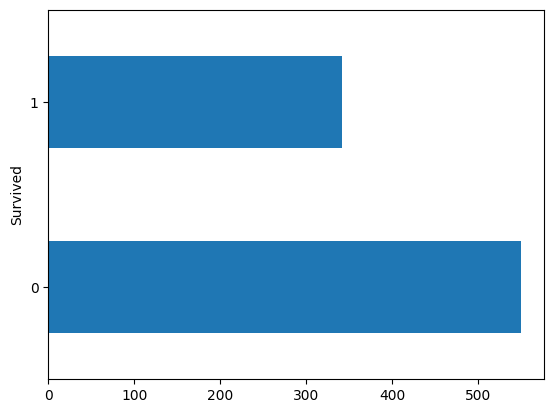

In [12]:
ax = train.Survived.value_counts().plot(kind='barh')

<Axes: xlabel='Sex'>

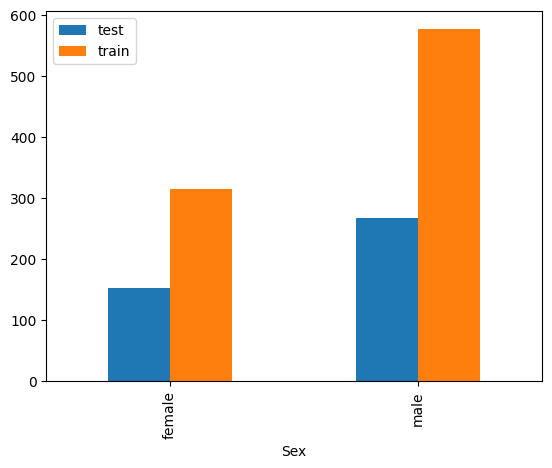

In [14]:
#Distribution by Gender
(pd.concat({'train': train, 'test': test})['Sex']
   .groupby(level=0).value_counts()
   .unstack(0)
   .plot.bar()
)

<Axes: xlabel='Pclass'>

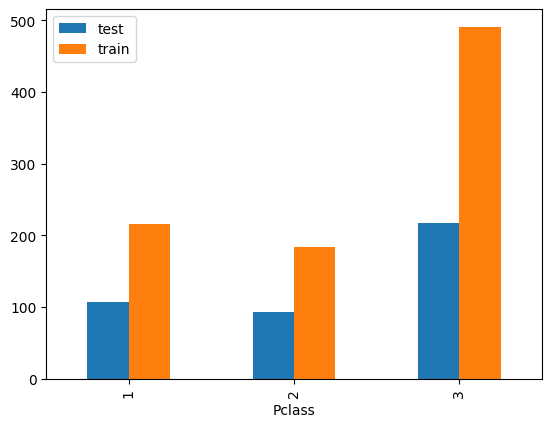

In [15]:
#Distribution by Pclass
(pd.concat({'train': train, 'test': test})['Pclass']
   .groupby(level=0).value_counts()
   .unstack(0)
   .plot.bar()
)

<Axes: xlabel='Embarked'>

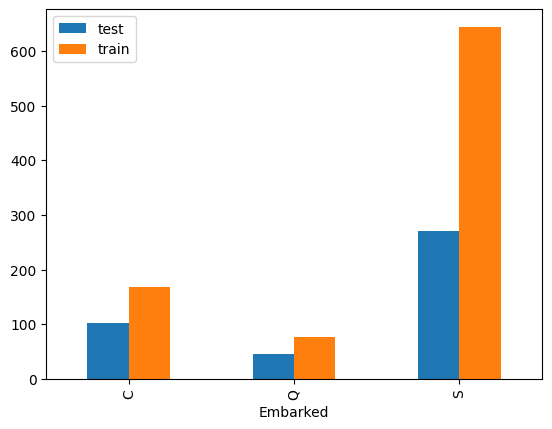

In [16]:
#Distribution by Embarked
(pd.concat({'train': train, 'test': test})['Embarked']
   .groupby(level=0).value_counts()
   .unstack(0)
   .plot.bar()
)

Text(0.5, 1.05, 'Blue: train \n Orange: test')

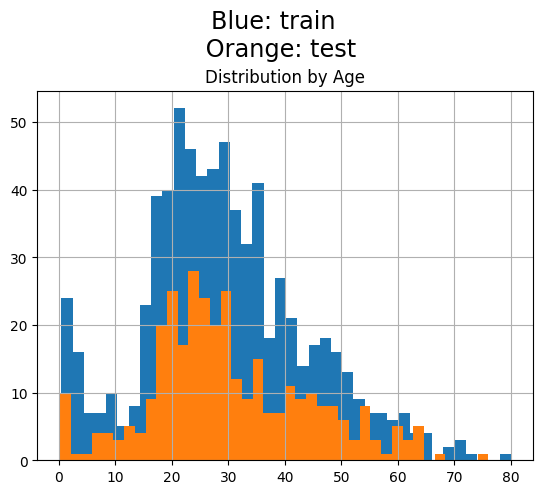

In [28]:
#Distribution by Age
%matplotlib inline

train['Age'].hist(bins=40)
test['Age'].hist(bins=40)
plt.title('Distribution by Age', ha='center')
plt.suptitle('Blue: train \n Orange: test', x=0.5, y=1.05, ha='center', fontsize='xx-large')

#### Dataset Summary --> test

The training data has 418 entries described by 11 features (6 numerical and 5 categorical).
Three columns have missing data: 
Age is missing 86 entries (20.5%).
Cabin is missing 327 entries (78.2%).

Gender, Pclass, Embarked and Age, are proportionately disgributed across the datasets, train and test.

### Clean Data: train, test

In [5]:
print('train:')
#drop 'Cabin' & impute Age, Embarked
train.drop('Cabin',  axis=1, inplace=True)
train['Age'].fillna(train['Age'].mean(), inplace = True)
train['Embarked'].fillna(train['Embarked'].mode()[0], inplace = True)
print(train.isna().sum())

train:
PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
dtype: int64


#### Cleaning Data Overview: train

Because Cabin is missing >75% of its values, it was dropped from train.

Missing values in Age were imputed with the average age of all passengers. 

Missing values for 'Embarked' were imputed with the mode.

Classifiers will be trained on the data set, train with 891 entries, 10 features (6 numerical & 4 categorical) and 1 outcome variable (Survived).

In [35]:
print('test:')
#drop 'Cabin' & impute Age, Embarked
test.drop('Cabin',  axis=1, inplace=True)
test['Age'].fillna(test['Age'].mean(), inplace = True)
print(test.isna().sum())

test:
PassengerId    0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           1
Embarked       0
dtype: int64


#### Cleaning Data Overview: test

Because the feature, Cabin, was dropped in the training dataset, it was also dropped in test.

Missing values for the feature, Age, were imputed using the mode (as was done in train).

The testing dataset has 418 entries with 10 features (6 numerical & 4 categorical).

### Feature Engineering

Create features: FarePerPerson, Title, AgeGroup

Drop features: Name, Ticket, Fare, Age

One Hot Encode: Sex, Embarked, Title, AgeGroup

In [6]:
#Create features: FarePerPerson, Title, AgeGroup
data = [train, test]
for dataset in data:
  # Create a fare per person feature
  dataset['FarePerPerson'] = (dataset['Fare'] / (dataset['SibSp'] + dataset['Parch'] + 1)).astype(float)
  # Extract Title from the Name column
  dataset['Title'] = dataset['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
  # Consolidate other titles into a single 'Other' category
  other_titles = ['Lady', 'Countess', 'Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona']
  dataset['Title'] = dataset['Title'].replace(other_titles, 'Other')
  # Extract An AgeGroup from the Age column
  dataset['AgeGroup'] = pd.cut(dataset['Age'], bins=[0, 12, 18, 60, np.inf], labels=['Child', 'Teenager', 'Adult', 'Senior'])


In [7]:
#Drop features: Name, Ticket, Fare, Age, SibSp, Parch
columns_to_drop = ['Name', 'Ticket', 'Fare', 'Age']

for dataset in data:
    dataset.drop(columns=columns_to_drop, inplace=True)

In [25]:
print(train.sample(5))
print(test.sample(5))

     PassengerId  Survived  Pclass     Sex  SibSp  Parch Embarked  \
291          292         1       1  female      1      0        C   
201          202         0       3    male      8      2        S   
488          489         0       3    male      0      0        S   
878          879         0       3    male      0      0        S   
233          234         1       3  female      4      2        S   

     FarePerPerson Title AgeGroup  
291      45.539600   Mrs    Adult  
201       6.322727    Mr    Adult  
488       8.050000    Mr    Adult  
878       7.895800    Mr    Adult  
233       4.483929  Miss    Child  
     PassengerId  Pclass     Sex  SibSp  Parch Embarked  FarePerPerson  \
7            899       2    male      1      1        S       9.666667   
164         1056       2    male      0      0        S      13.000000   
281         1173       3    male      1      1        S       4.591667   
310         1202       3    male      0      0        S       8.662500   

In [10]:
train.Title.unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Other', 'Mme', 'Ms', 'Mlle'],
      dtype=object)

#### Visualization: Distribution by New Features (AgeGroup, Title, FarePerPerson)

<Axes: xlabel='AgeGroup'>

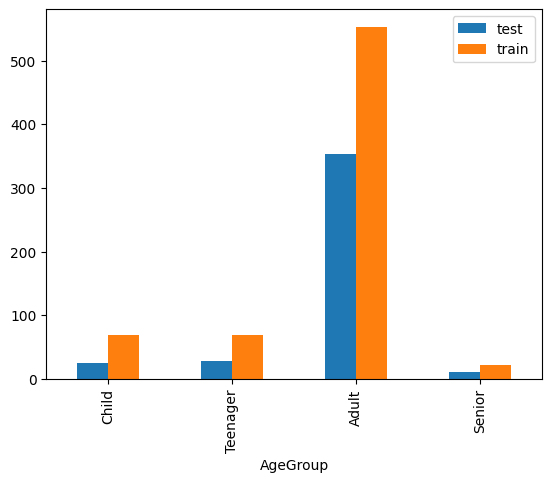

In [33]:
#Distribution by AgeGroup
(pd.concat({'train': train, 'test': test})['AgeGroup']
   .groupby(level=0).value_counts()
   .unstack(0)
   .plot.bar()
)

<Axes: xlabel='Title'>

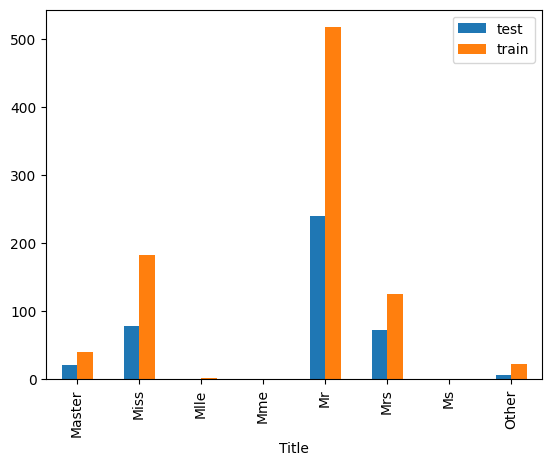

In [34]:
#Distribution by Title
(pd.concat({'train': train, 'test': test})['Title']
   .groupby(level=0).value_counts()
   .unstack(0)
   .plot.bar()
)

Text(0.5, 1.05, 'Blue: train \n Orange: test')

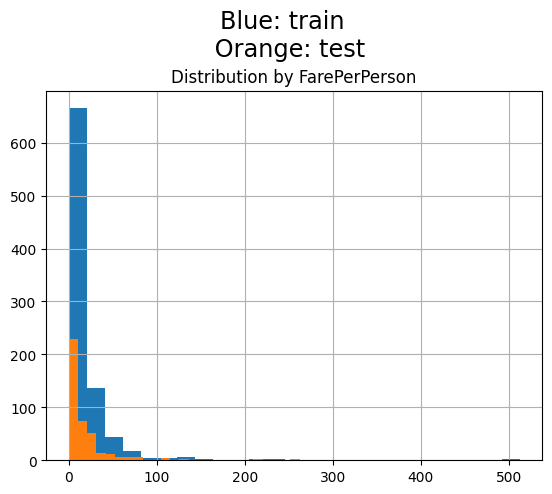

In [39]:
#Distribution of FarePerPerson
%matplotlib inline
train['FarePerPerson'].hist(bins=25)
test['FarePerPerson'].hist(bins=25)
plt.title('Distribution by FarePerPerson', ha='center')
plt.suptitle('Blue: train \n Orange: test', x=0.5, y=1.05, ha='center', fontsize='xx-large')

Engineered features are proportionately distributed across the datasets, train and test.

#### One Hot Encode Sex, AgeGroup, Title

In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   PassengerId    891 non-null    int64   
 1   Survived       891 non-null    int64   
 2   Pclass         891 non-null    int64   
 3   Sex            891 non-null    object  
 4   SibSp          891 non-null    int64   
 5   Parch          891 non-null    int64   
 6   Embarked       891 non-null    object  
 7   FarePerPerson  891 non-null    float64 
 8   Title          891 non-null    object  
 9   AgeGroup       891 non-null    category
dtypes: category(1), float64(1), int64(5), object(3)
memory usage: 63.8+ KB


In [11]:
#code source: https://www.geeksforgeeks.org/ml-one-hot-encoding/

data = [train, test]
encoded_data = []

for dataset in data:
    categorical_columns = dataset.select_dtypes(include=['object', 'category']).columns.tolist()
    print(categorical_columns)
    #Initialize OneHotEncoder
    encoder = OneHotEncoder(sparse_output=False)

    # Apply one-hot encoding to the categorical columns
    one_hot_encoded = encoder.fit_transform(dataset[categorical_columns])

    #Create a DataFrame with the one-hot encoded columns
    #We use get_feature_names_out() to get the column names for the encoded data
    one_hot_df = pd.DataFrame(one_hot_encoded, columns=encoder.get_feature_names_out(categorical_columns))

    # Concatenate the one-hot encoded dataframe with the original dataframe
    df_encoded = pd.concat([dataset, one_hot_df], axis=1)

    # Drop the original categorical columns
    df_encoded = df_encoded.drop(categorical_columns, axis=1)

    # Display the resulting dataframe
    print(f"Encoded data : \n{df_encoded}")

    encoded_data.append(df_encoded)

['Sex', 'Embarked', 'Title', 'AgeGroup']
Encoded data : 
     PassengerId  Survived  Pclass  SibSp  Parch  FarePerPerson  Sex_female  \
0              1         0       3      1      0        3.62500         0.0   
1              2         1       1      1      0       35.64165         1.0   
2              3         1       3      0      0        7.92500         1.0   
3              4         1       1      1      0       26.55000         1.0   
4              5         0       3      0      0        8.05000         0.0   
..           ...       ...     ...    ...    ...            ...         ...   
886          887         0       2      0      0       13.00000         0.0   
887          888         1       1      0      0       30.00000         1.0   
888          889         0       3      1      2        5.86250         1.0   
889          890         1       1      0      0       30.00000         0.0   
890          891         0       3      0      0        7.75000         0.

In [16]:
train, test = encoded_data[0], encoded_data[1]
print(train.info())
print(test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 23 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   PassengerId        891 non-null    int64  
 1   Survived           891 non-null    int64  
 2   Pclass             891 non-null    int64  
 3   SibSp              891 non-null    int64  
 4   Parch              891 non-null    int64  
 5   FarePerPerson      891 non-null    float64
 6   Sex_female         891 non-null    float64
 7   Sex_male           891 non-null    float64
 8   Embarked_C         891 non-null    float64
 9   Embarked_Q         891 non-null    float64
 10  Embarked_S         891 non-null    float64
 11  Title_Master       891 non-null    float64
 12  Title_Miss         891 non-null    float64
 13  Title_Mlle         891 non-null    float64
 14  Title_Mme          891 non-null    float64
 15  Title_Mr           891 non-null    float64
 16  Title_Mrs          891 non

#### Create X & y datasets

In [17]:
y_train=train.Survived
y_train.sample(5)

566    0
90     0
801    1
49     0
421    0
Name: Survived, dtype: int64

In [18]:
X_train = train.copy()
X_train.drop('Survived', axis=1, inplace=True)
X_train.sample(5)

,PassengerId,Pclass,SibSp,Parch,FarePerPerson,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,...,Title_Mlle,Title_Mme,Title_Mr,Title_Mrs,Title_Ms,Title_Other,AgeGroup_Adult,AgeGroup_Child,AgeGroup_Senior,AgeGroup_Teenager
139,140,1,0,0,79.200000,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
721,722,3,1,0,3.527100,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
824,825,3,4,1,6.614583,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
863,864,3,8,2,6.322727,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
68,69,3,4,2,1.132143,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


LR: 0.824919 (0.044419)
LDA: 0.826005 (0.043696)
KNN: 0.609401 (0.056297)
CART: 0.765418 (0.037492)
NB: 0.801348 (0.036238)
SVM: 0.631848 (0.052334)


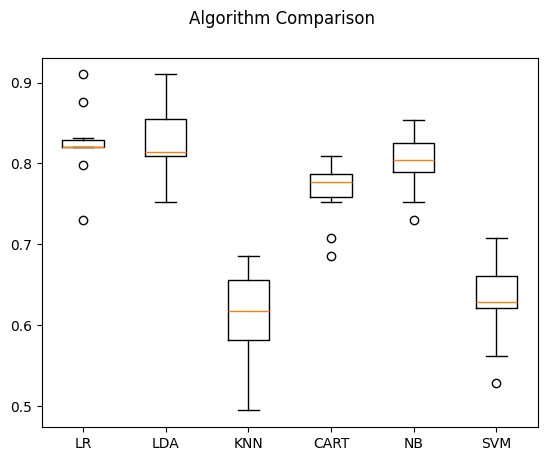

In [21]:
# prepare configuration for cross validation test harness
seed = 416
# prepare models
models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))
# evaluate each model, performance metric=accuracy
results = []
names = []
scoring = 'accuracy'
for name, model in models:
 kfold = model_selection.KFold(n_splits=10, random_state=seed, shuffle=True)
 cv_results = model_selection.cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
 results.append(cv_results)
 names.append(name)
 msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
 print(msg)
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

Results suggest that the models, logistic regression and linear discriminant analysis, are worthy of further exploration.